# Unit Checked Arithmetic via SIUnits

Units and dimensional analysis are standard tools across the sciences for checking the correctness of your equation. However, most ODE solvers only allow for the equation to be in dimensionless form, leaving it up to the user to both convert the equation to a dimensionless form, punch in the equations, and hopefully not make an error along the way.

DifferentialEquations.jl instead allows for one to use SIUnits.jl to have unit-checked arithmetic natively in the solvers. Given the dispatch implementation of the SIUnits, this has little overhead.

## Using SIUnits

To use SIUnits, you need to have the package installed. Then you can add units to your variables. For example:

In [1]:
using SIUnits
t = 1.5Second

1.5 s

Notice that `t` is a variable with units `Second`. If we make another value with seconds, they can add

In [2]:
t2 = 1.02Second
t+t2

2.52 s

and they can multiply:

In [3]:
t*t2

1.53 s²

Many operations work, though note that rational exponents are not allowed by SIUnits.jl, and so operations like `sqrt` are not allowed. For a shorthand way of defining units, we can bring in another module from the same package:

In [4]:
using SIUnits.ShortUnits
y = 1.5N
l = 0.31s

0.31 s

Now `N` is a shorthand for `Newton` and `s` for `Second`. Note that this is not done automatically so that the namespace is not clogged. These operations will check to make sure units are correct, and will throw an error for incorrect operations:

In [5]:
y+l

LoadError: LoadError: Unit mismatch. Got (kg m s⁻²) + (s)
while loading In[5], in expression starting on line 1

## Using SIUnits with DifferentialEquations.jl

Just like with other number systems, you can choose the units for your numbers by simply specifying the units of the initial condition and the timestep. For example, to solve the linear ODE where the variable has units of Newton's and `t` is in Seconds, we would use:

In [6]:
using DifferentialEquations
f = (t,y) -> 0.5*y
u₀ = 1.5Newton
prob = ODEProblem(f,u₀)

sol =solve(prob::ODEProblem,[0,1],Δt=(1/2^4)Second,save_timeseries=true,alg=:Midpoint)

INFO: Recompiling stale cache file /home/crackauc/.julia/lib/v0.5/DifferentialEquations.ji for module DifferentialEquations.
 in depwarn(::String, ::Symbol) at ./deprecated.jl:64
 in symbol(::String, ::Vararg{String,N}) at ./deprecated.jl:30
 in replace_t(::Expr) at /home/crackauc/.julia/v0.5/InplaceOps/src/InplaceOps.jl:97
 in collect_to!(::Array{Expr,1}, ::Base.Generator{Array{Any,1},InplaceOps.#replace_t}, ::Int64, ::Int64) at ./array.jl:337
 in collect(::Base.Generator{Array{Any,1},InplaceOps.#replace_t}) at ./array.jl:305
 in @into!(::Any) at /home/crackauc/.julia/v0.5/InplaceOps/src/InplaceOps.jl:120
 in macro expansion; at ./none:2 [inlined]
 in anonymous at ./<missing>:?
while loading /home/crackauc/.julia/v0.5/DifferentialEquations/src/ode/ode_integrators.jl, in expression starting on line 4039


LoadError: LoadError: Dimension mismatch in convert. Attempted to convert a (SIUnits.SIUnit{1,1,-2,0,0,0,0,0,0}) to (SIUnits.SIUnit{1,1,-3,0,0,0,0,0,0})
while loading In[6], in expression starting on line 6

Notice that we recieved a unit mismatch error. This is correctly so! Remember that for an ODE:

$$ \frac{dy}{dt} = f(t,y) $$

we must have that `f` is a rate, i.e. `f` is a change in `y` per unit time. So we need to fix the units of `f` in our example to be `N/s`. Notice that we then do not receive an error if we do the following:

In [7]:
f = (t,y) -> 0.5*y/3.0s
prob = ODEProblem(f,u₀)

sol =solve(prob::ODEProblem,[0,1],Δt=(1/2^4)Second,save_timeseries=true,alg=:Midpoint)

DifferentialEquations.ODESolution, 17 timesteps, final value 1.7720353197843262 kg m s⁻²

This gives a a normal solution object. Notice that the values are all with the correct units:

In [8]:
print(sol.timeseries)

SIUnits.SIQuantity{Float64,1,1,-2,0,0,0,0,0,0}[1.5 kg m s⁻²,1.51571 kg m s⁻²,1.53158 kg m s⁻²,1.54761 kg m s⁻²,1.56382 kg m s⁻²,1.58019 kg m s⁻²,1.59674 kg m s⁻²,1.61346 kg m s⁻²,1.63035 kg m s⁻²,1.64742 kg m s⁻²,1.66467 kg m s⁻²,1.68211 kg m s⁻²,1.69972 kg m s⁻²,1.71752 kg m s⁻²,1.7355 kg m s⁻²,1.75367 kg m s⁻²,1.77204 kg m s⁻²]

We can plot the solution using the plot recipe. Note that normally you would have to strip the units in order to plot, but DifferentialEquations.jl does this for you:

  likely near /home/crackauc/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /home/crackauc/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /home/crackauc/.julia/v0.5/IJulia/src/kernel.jl:31



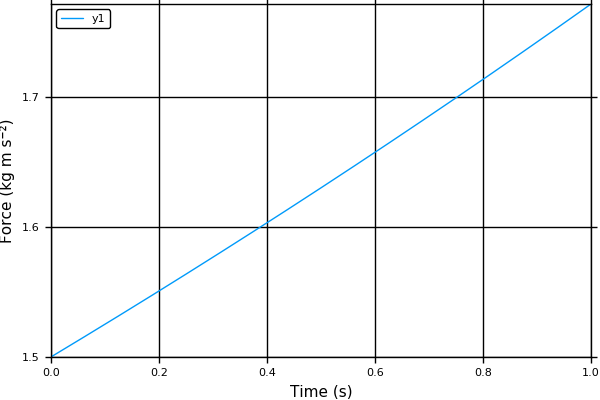

sys:1: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


In [11]:
plot(sol,yguide="Force ($(string(SIUnits.unit(sol.u))))",xguide="Time ($(string(SIUnits.unit(sol.t[1]))))",denseplot=false)

Notice that here we pulled the units for the label directly from the solution. Thus if the units change, the labels will change automatically.

## Other Solvers and Future Developments

As of right now, the ODE solvers are the only solvers which are fully compatible with units. The SDE solvers require there be rational coefficients for units since the natural time units for Brownian motion are $s^{(\frac12)}$ Since SIUnits do not support this, it will likely not be possible unless there is a change on their end. For the FEM PDE solvers, the tooling is all compatible with units (i.e. you can make meshes with units, and most of the functions will work). However, the solver step is what's not compatible with units. The reason is because `\` uses CHOLMOD which does not work with units, and sparse multiplication also is undefined for units. These facts are major stop gaps in development here. I believe it's not worth it to simply "turn off" units at that point because that is there area where one would wish to have units checked.

One avenue of further development is Unitful.jl. I am currently in contact with the developer of Unitful to add compatibility to DifferentialEquations.jl (with what has already been done, that should almost come for free). Since these units allow for rational coefficients, the SDE solvers will be compatible as well. These units allow for non SI units and will do the conversions, something that could make many scientists lives easier. If you have any more feature suggestions, please file an issue or feel free to discuss this in the Gitter chatroom.